In [10]:
!pip install causalml
!pip install scikit-uplift

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_by_percentile
from sklift.metrics import qini_auc_score
from imblearn.combine import SMOTEENN

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

In [12]:
df = pd.read_csv(f'dataframe2.csv',sep=(";")) 
cols =  ["treatment", "y_factual"] + [f'x{i}' for i in range(1,28)]
df.columns = cols

pd.Series(df['treatment']).value_counts(normalize=True)
df_copy= df.copy()
df_matriz = df_copy.loc[:,'x1':]
df_matriz= (df_matriz-df_matriz.min())/(df_matriz.max()-df_matriz.min())
df.loc[:,'x1':] = df_matriz

df

df_copy = df.copy()
nueva_matriz = np.random.uniform(0,0.0001, size=(14100,27))
nueva_matriz_ruido=nueva_matriz
df_matriz = df_copy.loc[:,'x1':]
df_matriz_ruid = df_matriz + nueva_matriz_ruido
df_copy.loc[:,'x1':]=df_matriz_ruid
df_copy


,treatment,y_factual,x1,x2,x3,x4,x5,x6,x7,x8,...,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27
0,0,0,0.000040,0.000071,0.000007,0.000064,0.000001,0.000017,0.000019,0.000044,...,0.000073,0.000002,0.000032,0.000024,0.000043,0.000087,7.280604e-05,0.000097,0.000071,0.000037
1,0,0,0.000080,0.000089,0.000002,0.000087,0.000032,0.000063,0.000058,0.000018,...,0.000090,0.000037,0.000054,0.000069,0.000064,0.000007,3.494959e-05,0.000098,0.000032,0.000026
2,1,1,1.000027,1.000090,0.750096,0.625058,0.000084,1.000065,0.000085,0.636456,...,0.000026,0.000060,0.000036,0.000001,0.000068,0.000066,9.877522e-05,0.000086,0.000065,0.000058
3,0,0,0.000081,0.000081,0.000074,0.000032,0.000062,0.000074,0.000047,0.000079,...,0.000028,0.000018,0.000067,0.000052,0.000003,0.000075,8.045410e-05,0.000065,0.000089,0.000020
4,0,0,0.000014,0.000018,0.000042,0.000095,0.000033,0.000054,0.000051,0.000055,...,0.000007,0.000035,0.000090,0.000012,0.000014,0.000072,7.996470e-05,0.000030,0.000032,0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14095,0,0,0.000097,0.000014,0.000084,0.000084,0.000054,0.000046,0.000025,0.000005,...,0.000082,0.000090,0.000090,0.000071,0.000082,0.000013,3.172320e-06,0.000031,0.000061,0.000084
14096,0,0,1.000034,1.000035,1.000037,0.000003,0.000056,0.000097,0.000082,0.136380,...,0.000052,0.000004,0.000090,0.000065,0.000024,0.000024,9.262461e-05,0.000012,0.000083,0.000093
14097,0,0,0.000040,0.000088,0.000027,0.000098,0.000033,0.000019,0.000006,0.000067,...,0.000076,0.000054,0.000068,0.000096,0.000091,0.000008,5.677040e-07,0.000087,0.000010,0.000054
14098,0,0,0.000045,0.000021,0.000029,0.000053,0.000028,0.000019,0.000068,0.000044,...,0.000049,0.000087,0.000033,0.000050,0.000075,0.000092,5.516000e-05,0.000060,0.000088,0.000071


In [13]:
df_int = df_copy.copy()
Y = df_int['y_factual']
treatment = df_int['treatment']
X = df_int.drop(['y_factual','treatment'],axis =1)

x_train, x_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X,treatment,Y, test_size= 0.3, random_state =0 ,stratify = Y)

dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(x_train, treatment_train.to_numpy()*1.0, y_train.to_numpy()*1.0)
dragon_ate = dragon_ite.mean()



Epoch 1/30
124/124 [==============================] - 2s 6ms/step - loss: 23.8906 - regression_loss: 0.9244 - binary_classification_loss: 17.7987 - treatment_accuracy: 0.8774 - track_epsilon: 0.0593 - val_loss: 18.0764 - val_regression_loss: 0.4561 - val_binary_classification_loss: 13.5796 - val_treatment_accuracy: 0.9116 - val_track_epsilon: 0.0313
Epoch 2/30
124/124 [==============================] - 0s 4ms/step - loss: 17.5865 - regression_loss: 0.5545 - binary_classification_loss: 13.3771 - treatment_accuracy: 0.8938 - track_epsilon: 0.0170 - val_loss: 17.1247 - val_regression_loss: 0.3549 - val_binary_classification_loss: 13.7568 - val_treatment_accuracy: 0.8580 - val_track_epsilon: 0.0068
Epoch 3/30
124/124 [==============================] - 0s 3ms/step - loss: 16.5368 - regression_loss: 0.5134 - binary_classification_loss: 13.1436 - treatment_accuracy: 0.8981 - track_epsilon: 0.0027 - val_loss: 15.3241 - val_regression_loss: 0.3629 - val_binary_classification_loss: 12.5785 - val

Epoch 15/300
124/124 [==============================] - 0s 3ms/step - loss: 10.8786 - regression_loss: 0.4502 - binary_classification_loss: 9.2701 - treatment_accuracy: 0.9249 - track_epsilon: 9.4954e-04 - val_loss: 10.7828 - val_regression_loss: 0.2996 - val_binary_classification_loss: 9.5100 - val_treatment_accuracy: 0.9241 - val_track_epsilon: 6.4440e-04
Epoch 16/300
124/124 [==============================] - 0s 3ms/step - loss: 10.8854 - regression_loss: 0.4500 - binary_classification_loss: 9.2784 - treatment_accuracy: 0.9241 - track_epsilon: 0.0014 - val_loss: 10.7849 - val_regression_loss: 0.3005 - val_binary_classification_loss: 9.5115 - val_treatment_accuracy: 0.9221 - val_track_epsilon: 0.0020
Epoch 17/300
124/124 [==============================] - 0s 3ms/step - loss: 10.8558 - regression_loss: 0.4501 - binary_classification_loss: 9.2674 - treatment_accuracy: 0.9220 - track_epsilon: 0.0011 - val_loss: 10.7342 - val_regression_loss: 0.2997 - val_binary_classification_loss: 9.46

124/124 [==============================] - 0s 4ms/step - loss: 10.8056 - regression_loss: 0.4493 - binary_classification_loss: 9.2109 - treatment_accuracy: 0.9246 - track_epsilon: 6.5253e-04 - val_loss: 10.7328 - val_regression_loss: 0.3002 - val_binary_classification_loss: 9.4622 - val_treatment_accuracy: 0.9270 - val_track_epsilon: 6.2272e-04

Epoch 00037: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 38/300
124/124 [==============================] - 0s 4ms/step - loss: 10.7920 - regression_loss: 0.4493 - binary_classification_loss: 9.2076 - treatment_accuracy: 0.9231 - track_epsilon: 6.2769e-04 - val_loss: 10.7340 - val_regression_loss: 0.3002 - val_binary_classification_loss: 9.4634 - val_treatment_accuracy: 0.9281 - val_track_epsilon: 6.8080e-04
Epoch 39/300
124/124 [==============================] - 0s 4ms/step - loss: 10.7806 - regression_loss: 0.4492 - binary_classification_loss: 9.2080 - treatment_accuracy: 0.9240 - track_epsilon: 5.8444e-04 - val_los

Epoch 59/300
124/124 [==============================] - 0s 3ms/step - loss: 10.8020 - regression_loss: 0.4492 - binary_classification_loss: 9.2029 - treatment_accuracy: 0.9262 - track_epsilon: 6.2615e-04 - val_loss: 10.7355 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.4651 - val_treatment_accuracy: 0.9291 - val_track_epsilon: 6.2730e-04

Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.
Epoch 60/300
124/124 [==============================] - 0s 4ms/step - loss: 10.7968 - regression_loss: 0.4492 - binary_classification_loss: 9.2026 - treatment_accuracy: 0.9261 - track_epsilon: 6.2535e-04 - val_loss: 10.7355 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.4650 - val_treatment_accuracy: 0.9291 - val_track_epsilon: 6.2804e-04
Epoch 61/300
124/124 [==============================] - 0s 3ms/step - loss: 10.7997 - regression_loss: 0.4492 - binary_classification_loss: 9.2025 - treatment_accuracy: 0.9258 - track_epsilon: 6.3004

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0558'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

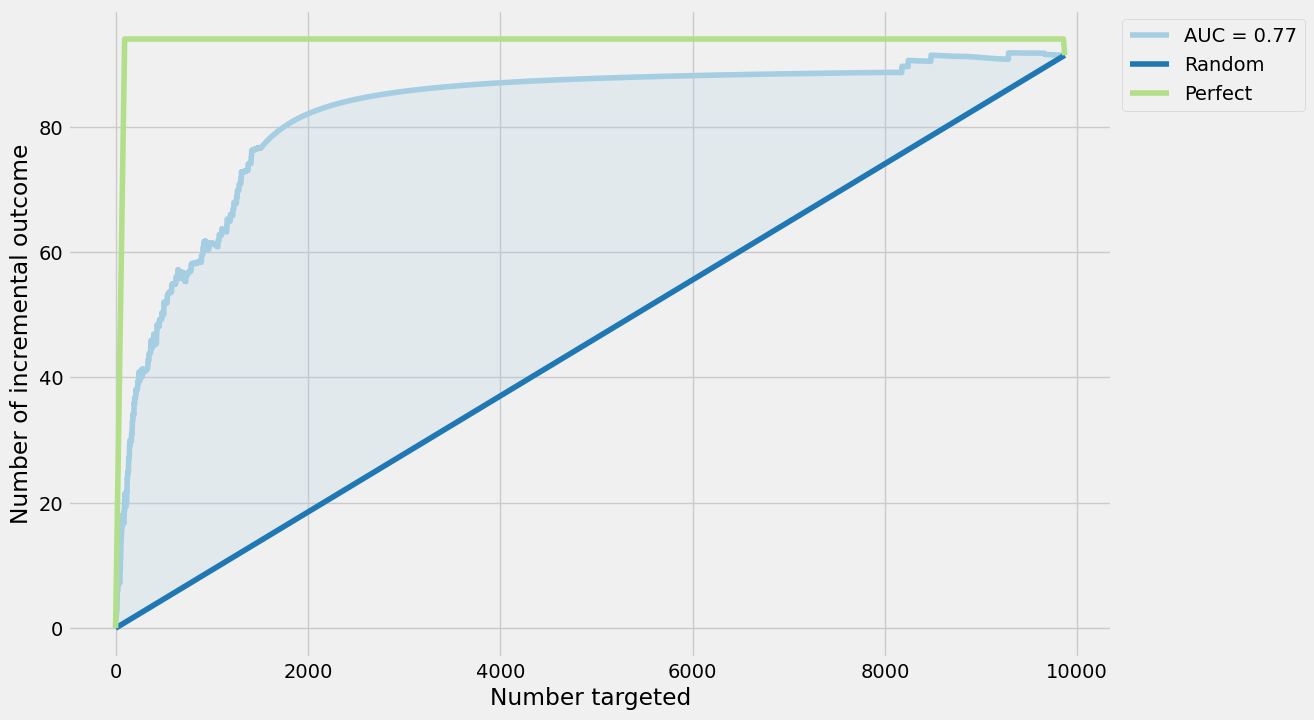

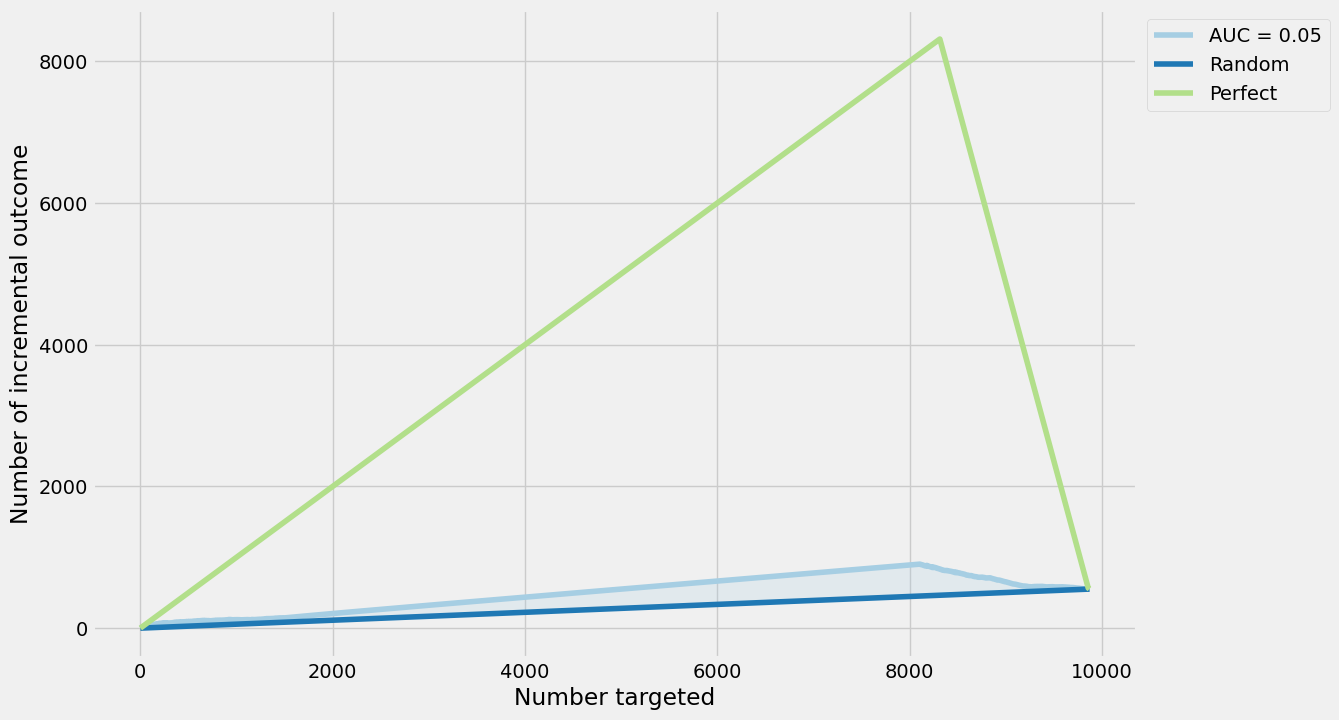

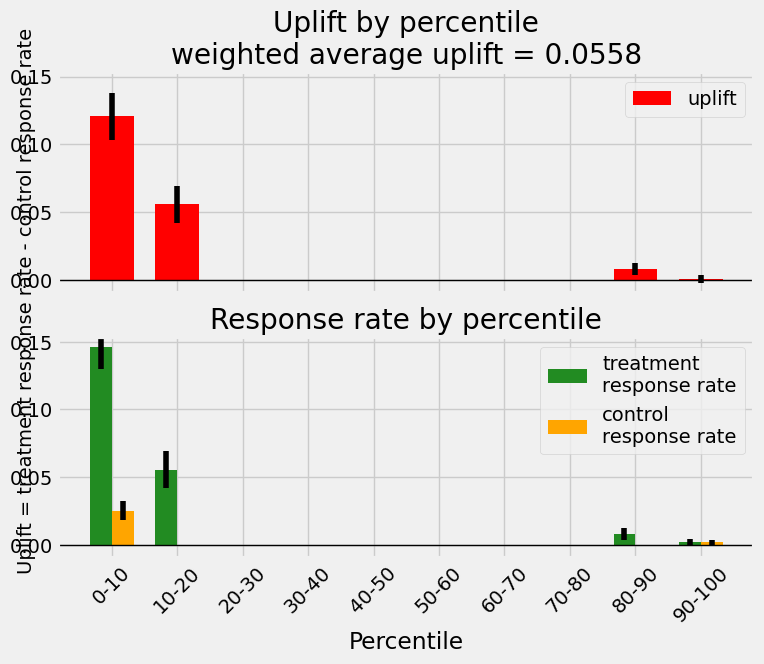

In [14]:
data = {'y_to_pred':y_train, 'uplift':dragon_ite[:,0] , 'treatment':treatment_train}
qini = qini_auc_score(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])

#data.sort_values( by=['uplift'] )
plot_qini_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_by_percentile(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'],kind='bar') 

In [ ]:
def plot_uplift_curve1(y_true, uplift, treatment,
                      random=True, perfect=True, ax=None, name=None, **kwargs):
    """Plot Uplift curves from predictions.

    Args:
        y_true (1d array-like): Ground truth (correct) binary labels.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        random (bool): Draw a random curve. Default is True.
        perfect (bool): Draw a perfect curve. Default is True.
        ax (object): The graph on which the function will be built. Default is None.
        name (string): The name of the function. Default is None.

    Returns:
        Object that stores computed values.

    Example::

        from sklift.viz import plot_uplift_curve


        uplift_disp = plot_uplift_curve(
            y_test, uplift_predicted, trmnt_test,
            perfect=True, name='Model name'
        );

        uplift_disp.figure_.suptitle("Uplift curve");
    """
    #check_matplotlib_support('plot_uplift_curve')
    #check_consistent_length(y_true, uplift, treatment)
    #check_is_binary(treatment)
   # check_is_binary(y_true)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)
    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)

    if random:
        x_baseline, y_baseline = x_actual, x_actual * y_actual[-1] / len(y_true)
    else:
        x_baseline, y_baseline = None, None

    if perfect:
        x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    else:
        x_perfect, y_perfect = None, None

    viz = UpliftCurveDisplay(
        x_actual=x_actual,
        y_actual=y_actual,
        x_baseline=x_baseline,
        y_baseline=y_baseline,
        x_perfect=x_perfect,
        y_perfect=y_perfect,
        random=random,
        perfect=perfect,
        estimator_name=name,
    )

    auc = uplift_auc_score(y_true, uplift, treatment)
    

    return viz.plot(auc, ax=ax, title="AUC", **kwargs)


In [ ]:
def uplift_auc_score(y_true, uplift, treatment):
    """Compute normalized Area Under the Uplift Curve from prediction scores.
    By computing the area under the Uplift curve, the curve information is summarized in one number.
    For binary outcomes the ratio of the actual uplift gains curve above the diagonal to that of
    the optimum Uplift Curve.
    Args:
        y_true (1d array-like): Correct (true) binary target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        float: Area Under the Uplift Curve.
    See also:
        :func:`.uplift_curve`: Compute Uplift curve.
        :func:`.perfect_uplift_curve`: Compute the perfect (optimum) Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_auc_score`: Compute normalized Area Under the Qini Curve from prediction scores.
    """

   # check_consistent_length(y_true, uplift, treatment)
    #check_is_binary(treatment)
    #check_is_binary(y_true)
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [ ]:
from sklearn.metrics import auc
y_true, uplift, treatment = np.array(y), np.array(dragon_ite[:,0]), np.array(treatment)
print(uplift)
x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
auc_actual=auc(x_actual,y_actual)
print('tr',auc_actual)
print(x_actual)
print(y_actual)

[-0.26104206 -0.26104206  0.05306383 ... -0.26104206 -0.26104206
 -0.06434052]
[-0.26425147 -0.2641539  -0.26394618 ...  0.23008323  0.25204372
  0.25263798]
y (14100,)
[-0.26425147 -0.2641539  -0.26394618 ...  0.23008323  0.25204372
  0.25263798]
z [7268 7265 7502 ... 8468 7883 9233]
y (14100,)
x [-0.26425147 -0.2641539  -0.26394618 ...  0.23008323  0.25204372
  0.25263798]
a [1 0 0 ... 0 0 0]
d [ 0.25263798  0.25204372  0.23008323 ... -0.2641539  -0.2641539
 -0.26425147]
b [    0     1     2 ... 14095 14096 14098]
c [    0     1     2 ... 14096 14098 14099]
tr 5078122.472407559
[    0     1     2 ... 14097 14099 14100]
[  0.           1.           2.         ... 765.53763952 765.65073061
 765.70727606]


In [ ]:
def uplift_curve(y_true, uplift, treatment):
    """Compute Uplift curve.
    For computing the area under the Uplift Curve, see :func:`.uplift_auc_score`.
    Args:
        y_true (1d array-like): Correct (true) binary target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.
    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.
        :func:`.perfect_uplift_curve`: Compute the perfect Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_curve`: Compute Qini curve.
    References:
        Devriendt, F., Guns, T., & Verbeke, W. (2020). Learning to rank for uplift modeling. ArXiv, abs/2002.05897.
    """

    #check_consistent_length(y_true, uplift, treatment)
    #check_is_binary(treatment)
    #check_is_binary(y_true)
    print(np.unique(uplift))
    print('y',uplift.shape)
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)
    print(np.unique(uplift))
    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]
    print('z',desc_score_indices)
    print('y',uplift.shape)
    print('x',np.unique(uplift))
    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0
    print('a',treatment)

    distinct_value_indices = np.where(np.diff(uplift))[0]
    print('d',uplift)
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]
    print('b',distinct_value_indices)
    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]
    print('c',threshold_indices)

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


In [ ]:
cifar train test = cifar10(ajshdjashdjashdjashdjksadhkjsa tranform = transform.totensor())